### Raw Profile generation functions from GATK Report

In [69]:
import logging
from log_utils import initialize_logger
from br_stat_profiler import harvest_recal_tables
from user_args import UARGS 
from constants import RC_TAB2
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
from math import pow
# TUPULES_COL = "Q_Tuple"
from constants import RC_TAB2, RT2_STAT


class PROFILE_TYPES:
    TUPULES_COL         = "Tuple"
    DELTA_Q_PHRED_COL   = "DeltaQ_Phred"
    DELTA_Q_FOLD_COL       = "DeltaQ_FOLD"
    AVG_Q_COL           = "AverageQ"
    EMP_Q_COL           = "EmpQ"

def get_profile_results(df, profile_type):
    for colidx in df.columns.levels[1]:
        if not colidx:
            continue
        temp_df = df.xs(colidx, axis=1, level=RC_TAB2.RG_COL)
        if profile_type == PROFILE_TYPES.TUPULES_COL:
            new_col = list(zip(temp_df[RC_TAB2.QLTY_SCORE_COL], temp_df[RC_TAB2.EMP_QLTY_COL]))
                        
        elif profile_type == PROFILE_TYPES.DELTA_Q_PHRED_COL:
            new_col =  temp_df[RC_TAB2.EMP_QLTY_COL] - temp_df[RC_TAB2.QLTY_SCORE_COL]
        
        elif profile_type == PROFILE_TYPES.AVG_Q_COL:
            new_col = (temp_df[RC_TAB2.QLTY_SCORE_COL] + temp_df[RC_TAB2.EMP_QLTY_COL])/2
        
        elif profile_type == PROFILE_TYPES.DELTA_Q_FOLD_COL:
            delta_phreds = temp_df[RC_TAB2.QLTY_SCORE_COL] - temp_df[RC_TAB2.EMP_QLTY_COL]  # deltaQ
            delta_pvals = [pow(10, -score/10) for score in delta_phreds]  # phred to  pvals
            # pval to fold
            new_col =  [-1*(1/item) if item < 1 else item for item in delta_pvals] 
        
        elif profile_type == PROFILE_TYPES.EMP_Q_COL:
            new_col =  temp_df[RC_TAB2.EMP_QLTY_COL]
                                    
        df[(profile_type, colidx)] =  new_col
    return df.xs(profile_type, axis=1,level=0)
        

def min_max_scaling(df, scaler):
    df_copy = df[[RC_TAB2.RG_COL, 
                            RC_TAB2.CNTXT_COV, 
                            RC_TAB2.QLTY_SCORE_COL, 
                            RC_TAB2.EMP_QLTY_COL]].copy()
    
    df_copy[RC_TAB2.QLTY_SCORE_COL] = \
        scaler.fit_transform(df_copy[[RC_TAB2.QLTY_SCORE_COL]]).astype(int)
    df_copy[RC_TAB2.EMP_QLTY_COL] = \
        scaler.fit_transform(df_copy[[RC_TAB2.EMP_QLTY_COL]]).astype(int)
    return df_copy

def get_GATK_rec_table2(filename):
    my_dict = {}
    my_dict[UARGS.INFILE] = open(filename,"r")  
    return harvest_recal_tables(my_dict)[RC_TAB2.NAME]

def average_duplicates(df): # averaging Emp data in the case of duplicates RG
    RG_COL_NEW = RC_TAB2.RG_COL + "New"
    EMP_QLTY_COL_NEW = RC_TAB2.EMP_QLTY_COL + "New"
    df[RG_COL_NEW] = df[RC_TAB2.RG_COL].apply(lambda x: x.split(':')[0])
    return df.groupby([RG_COL_NEW, RC_TAB2.QLTY_SCORE_COL, RC_TAB2.CNTXT_COV])\
        .agg(**{
                EMP_QLTY_COL_NEW : (RC_TAB2.EMP_QLTY_COL, 'mean')})\
                    .reset_index()\
                        .rename(columns={RG_COL_NEW: RC_TAB2.RG_COL,
                                EMP_QLTY_COL_NEW : RC_TAB2.EMP_QLTY_COL})

class RAW_PROFILE_ARGS:
        MIN_RANGE       = "min_range"
        MAX_RANGE       = "max_range"
        CUTOFF_QTL      = "cutoff_qunatile"
        PROFILE_TYPE    = "profile_type"


def generate_raw_profile(gatk_report, args):
    rec_tab2 = get_GATK_rec_table2(gatk_report)
    profile_type = args[RAW_PROFILE_ARGS.PROFILE_TYPE]
    # filter the requested covariate type, change column name
    rec_tab2 = rec_tab2[rec_tab2[RC_TAB2.COV_NAME_COL] == RC_TAB2.CNTXT_COV]\
        .rename(columns={RC_TAB2.COV_VAL_COL: RC_TAB2.CNTXT_COV})

    rec_tab2_avg = average_duplicates(rec_tab2)

    scaler = MinMaxScaler(feature_range=(args[RAW_PROFILE_ARGS.MIN_RANGE],
                                     args[RAW_PROFILE_ARGS.MAX_RANGE]))
    rec_tab2_scaled = min_max_scaling(rec_tab2_avg, scaler)

    # adding Id column
    rec_tab2_scaled[RT2_STAT.ID_COL] = \
        rec_tab2_scaled[[RC_TAB2.CNTXT_COV, RC_TAB2.QLTY_SCORE_COL]].astype(str).apply(lambda row:RT2_STAT.ID_DELIM.join(list(row)) , axis=1) 

    q_err_profile_df = rec_tab2_scaled.pivot_table(
        columns=RC_TAB2.RG_COL, 
        values=[RC_TAB2.QLTY_SCORE_COL, RC_TAB2.EMP_QLTY_COL],
        index = RT2_STAT.ID_COL).reset_index() 

    q_err_profile_df = q_err_profile_df.set_index(RT2_STAT.ID_COL)

    return get_profile_results(q_err_profile_df, profile_type)


#### Test - generation of a single profile

In [70]:

user_agrs = {
    RAW_PROFILE_ARGS.MIN_RANGE      : 1, 
    RAW_PROFILE_ARGS.MAX_RANGE      : 40,
    # RAW_PROFILE_ARGS.CUTOFF_QTL   : 0.5
    RAW_PROFILE_ARGS.PROFILE_TYPE :  PROFILE_TYPES.DELTA_Q_PHRED_COL,
    # RAW_PROFILE_ARGS.PROFILE_TYPE   :  PROFILE_TYPES.DELTA_Q_FOLD_COL,
    # RAW_PROFILE_ARGS.PROFILE_TYPE :  PROFILE_TYPES.EMP_Q_COL,
}

GATK_REPORT_FILE = "/home/ido/br_stat_profiler/data/test_bqsr/HKNPC-101T.bam.GATKReport.mm_cntxt.4"
raw_profile = generate_raw_profile(GATK_REPORT_FILE, user_agrs)
raw_profile.describe()

ReadGroup,C69FGACXX
count,9138.000000
mean,4.754870
std,4.819869
min,-15.000000
25%,2.000000
50%,5.000000
75%,8.000000
max,22.000000


### Generation of multiple profile concatenated 
1) adjust user_args
2) uncoment last raw for activation

In [71]:

user_agrs = {
    RAW_PROFILE_ARGS.MIN_RANGE : 1, 
    RAW_PROFILE_ARGS.MAX_RANGE : 40,
    # RAW_PROFILE_ARGS.PROFILE_TYPE :  PROFILE_TYPES.TUPULES_COL,
    # RAW_PROFILE_ARGS.PROFILE_TYPE :  PROFILE_TYPES.AVG_Q_COL,
    RAW_PROFILE_ARGS.PROFILE_TYPE :  PROFILE_TYPES.DELTA_Q_PHRED_COL,
    # RAW_PROFILE_ARGS.PROFILE_TYPE    :  PROFILE_TYPES.DELTA_Q_FOLD_COL,
    # RAW_PROFILE_ARGS.PROFILE_TYPE   :  PROFILE_TYPES.EMP_Q_COL,
}

MAIN_DIR = "/media/storage/ido/test_profiler/NPC_2017/"

samples_dict = {}
samples_dict["SAMEA3879638"]="HKNPC-087N.bam"
samples_dict["SAMEA3879639"]="HKNPC-087T.bam"
samples_dict["SAMEA3879640"]="HKNPC-088N.bam"
samples_dict["SAMEA3879641"]="HKNPC-088T.bam"
samples_dict["SAMEA3879642"]="HKNPC-089N.bam"
samples_dict["SAMEA3879643"]="HKNPC-089T.bam"
samples_dict["SAMEA3879644"]="HKNPC-090N.bam"   # C5BCAACXX
samples_dict["SAMEA3879645"]="HKNPC-090T.bam"   # C59HJACXX
samples_dict["SAMEA3879646"]="HKNPC-101N.bam"   # C69FGACXX
samples_dict["SAMEA3879647"]="HKNPC-101T.bam"   # C69FGACXX
import os
# construct list of file
def gatk_report_suffix(number):
    return "GATKReport.mm_cntxt." + str(number)

def get_full_path(files_dict, dir, number):
    files = []
    for key, value in files_dict.items():
        temp_dir  = os.path.join(dir, key)  
        filename = f"{files_dict[key]}.{gatk_report_suffix(number)}"
        fullpath = os.path.join(temp_dir, filename)
        files.append(fullpath)
    return files

# def save_merged_profiles
# outfile  = gatk_report_suffix(number)

import pandas as pd
def save_merged_profiles(samples_dict, main_dir, number, 
                         args = user_agrs):
    profile_type = args[RAW_PROFILE_ARGS.PROFILE_TYPE]
    outfilename = f"All.RawProfile.{profile_type}.{gatk_report_suffix(number)}"
    outfile_fullpath = os.path.join(main_dir, outfilename)
    gatk_files = get_full_path(samples_dict,MAIN_DIR, number)
    raw_profiles = []
    for file in gatk_files:
        raw_profile = generate_raw_profile(file, args)
        raw_profiles.append(raw_profile)
    print(outfile_fullpath)
    print(args)
    result = pd.concat(raw_profiles, axis=1, join='inner')
    result.columns  = list(samples_dict.values())
    csv_outfile = outfile_fullpath + ".csv"
    print(csv_outfile)
    result.to_csv(csv_outfile, mode='x')
    
    # write log file with files and argments
    log_outfile = outfile_fullpath + ".log"
    print(log_outfile)
    with open(log_outfile, 'x') as fd:
        for key, value in args.items():
            fd.write(f'{key}: {value}\n')
        for g_file in gatk_files:
            fd.write(f'{g_file}\n')

# save_merged_profiles(samples_dict, MAIN_DIR, 6)

In [72]:
import matplotlib as mpl

# Reset default settings
mpl.rcParams.update(mpl.rcParamsDefault)


#### Data preparation for clustering

In [73]:
import os
from sklearn.preprocessing import StandardScaler

PROFILES_DIR    = "/media/storage/ido/test_profiler/NPC_2017"
PROFILES_6       = [
    "All.RawProfile.AverageQ.GATKReport.mm_cntxt.6.csv",
    "All.RawProfile.DeltaQ_Phred.GATKReport.mm_cntxt.6.csv",
    "All.RawProfile.DeltaQ_FOLD.GATKReport.mm_cntxt.6.csv",
    "All.RawProfile.EmpQ.GATKReport.mm_cntxt.6.csv"
    ]
FPATH_PROFILES_6  = [os.path.join(PROFILES_DIR, file) for file in PROFILES_6]
PROFILES_4       = [
    "All.RawProfile.AverageQ.GATKReport.mm_cntxt.4.csv",
    "All.RawProfile.DeltaQ_Phred.GATKReport.mm_cntxt.4.csv",
    "All.RawProfile.DeltaQ_FOLD.GATKReport.mm_cntxt.4.csv",
    "All.RawProfile.EmpQ.GATKReport.mm_cntxt.4.csv"
    ]

FPATH_PROFILES_4  = [os.path.join(PROFILES_DIR, file) for file in PROFILES_4]


def get_profile_data(filename, scaled=True):
    profile_df = pd.read_csv(filename)
    X_profile = profile_df.iloc[:, 1:].values
    X_columns = profile_df.iloc[:, 1:].columns
    if scaled:
        scaler = StandardScaler()
        X_profile = scaler.fit_transform(X_profile) # by columns
    return X_profile, X_columns


#### Scipy clustering using linkage() followed by dendogram()

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_hclust_dendogram(X_profile, X_labels, title, hclust_method = 'ward', hclust_metric = 'euclidean'):
    Z = linkage(X_profile.T, method=hclust_method, metric=hclust_metric)
    dendrogram(Z, labels = X_labels)
# Z = linkage(X_profile.T, method='ward', metric='euclidean')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

def plot_profiles_list(profiles_list, method = "ward"):
    for i, profiles in enumerate(profiles_list):
        X_scaled, X_cols = get_profile_data(profiles, True)
        filename = os.path.basename(profiles_list[i])
        plot_hclust_dendogram(X_scaled, X_cols,filename, method)

#### Hierarchical clustering using scipy linkage with varios methos
methods: ward, centroid, average, median

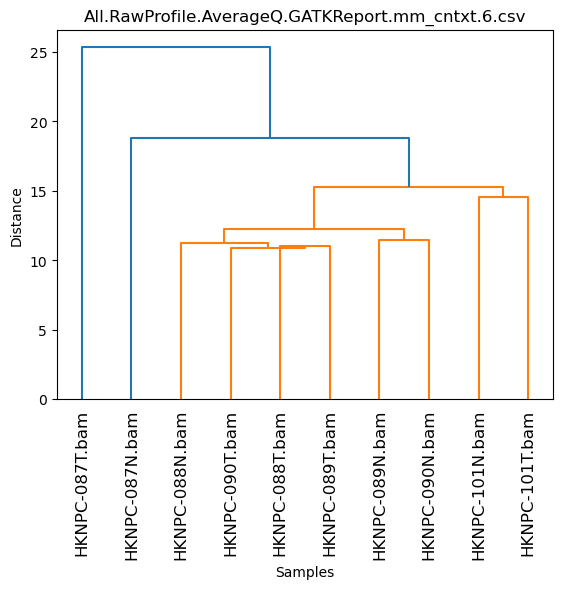

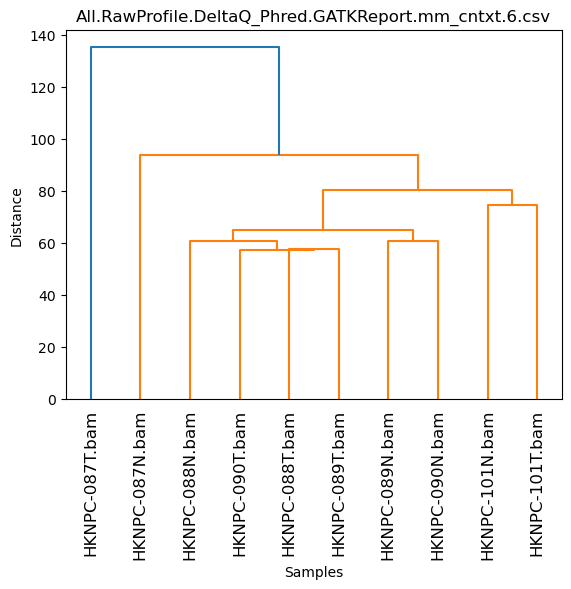

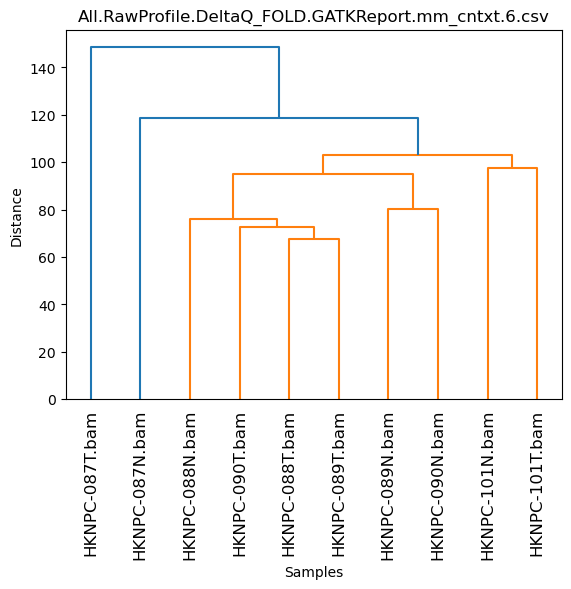

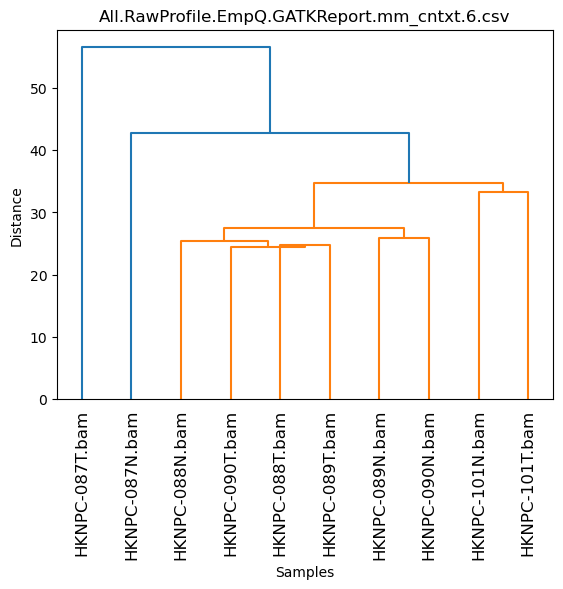

In [61]:
from sklearn.preprocessing import StandardScaler

plot_profiles_list(FPATH_PROFILES_6, "centroid")

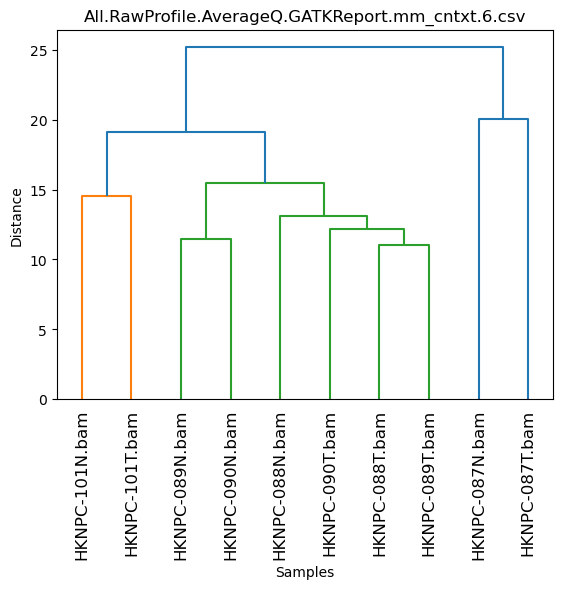

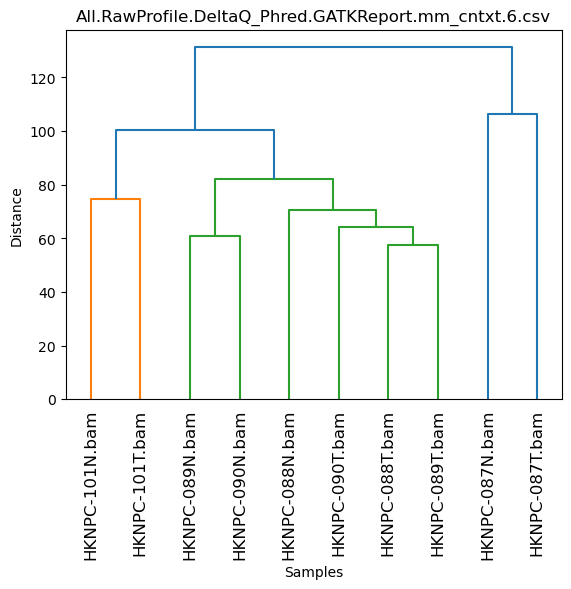

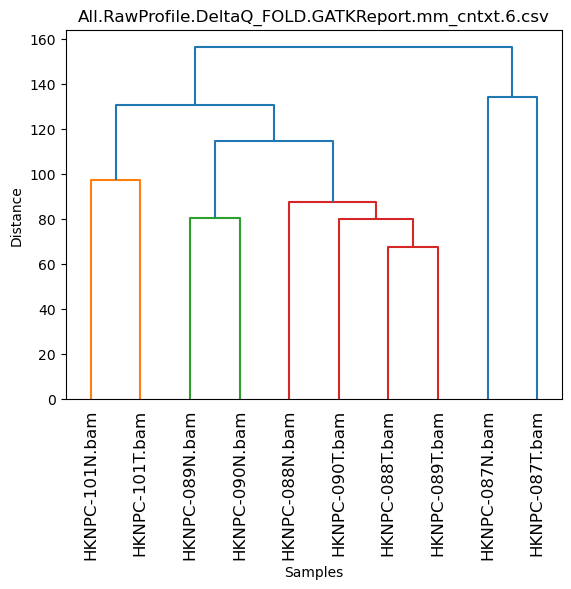

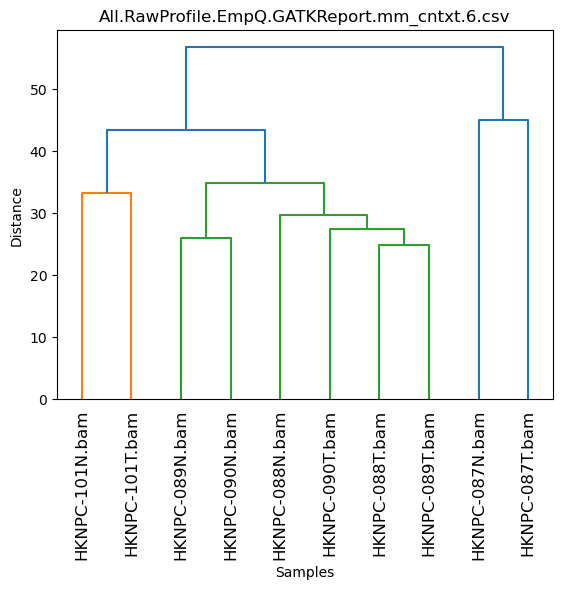

In [62]:

    
plot_profiles_list(FPATH_PROFILES_6, "average")

#### HDBScan hierarchical clustering (failed)

Sahpe (141648, 10)


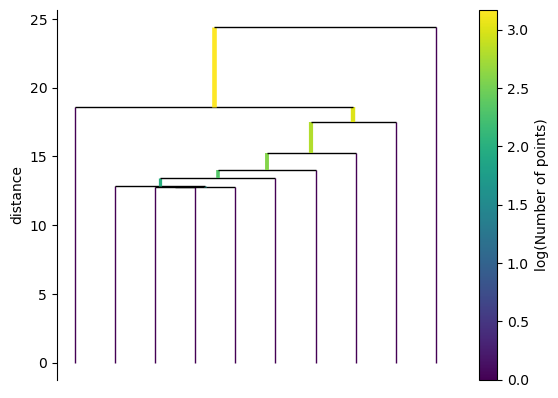

All.RawProfile.AverageQ.GATKReport.mm_cntxt.6.csv
-1    10
dtype: int64
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Sahpe (141648, 10)


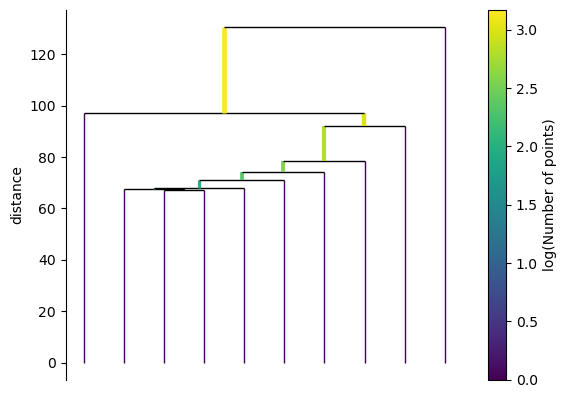

All.RawProfile.DeltaQ_Phred.GATKReport.mm_cntxt.6.csv
-1    10
dtype: int64
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Sahpe (141648, 10)


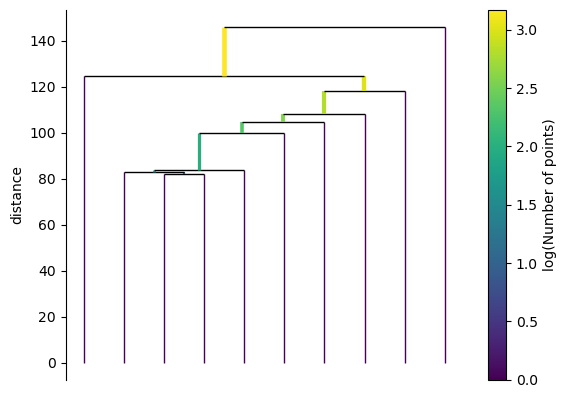

All.RawProfile.DeltaQ_FOLD.GATKReport.mm_cntxt.6.csv
-1    10
dtype: int64
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Sahpe (141648, 10)


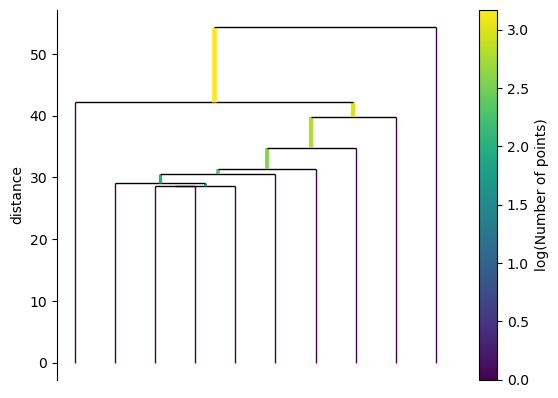

All.RawProfile.EmpQ.GATKReport.mm_cntxt.6.csv
-1    10
dtype: int64
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [119]:
import hdbscan
import numpy as np

np.random.seed(0)
X_HDBS_EXAMPLE = np.random.randn(100, 2)  # 100 samples with 2 features

# Perform clustering with HDBSCAN
def HDBSCAN_test(files_list, min_clust_sz=2, scale=True):
    for file in files_list:
        X, X_cols = get_profile_data(file, scale)
        print("Sahpe", X.shape)
        clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
        labels = clusterer.fit_predict(X.T)
        clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
        plt.show()
        print(os.path.basename(file))
        labels_pd = pd.Series(labels)
        print(labels_pd.value_counts())
        print(labels)
    
HDBSCAN_test(FPATH_PROFILES_6, 2, True)



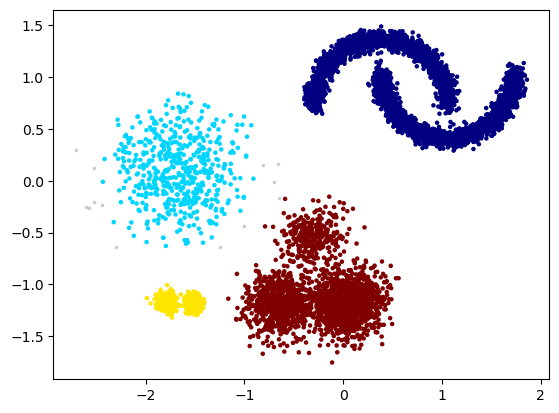

Unique labels (-1 for outliers): [-1  0  1  2  3]


In [110]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from hdbscan import HDBSCAN
from hdbscan.flat import (HDBSCAN_flat,
                          approximate_predict_flat,
                          membership_vector_flat,
                          all_points_membership_vectors_flat)

centers = [(0, 2), (-0.2, 0), (0.2, 0),
           (1.5, 0), (2., 1.), (2.5, 0.)]
std = [0.5, 0.08, 0.06, 0.25, 0.25, 0.25]
X, y = make_blobs(n_samples=[700, 300, 800, 1000, 400, 1500],
                  centers=centers,
                  cluster_std=std)
X1, y1 = make_moons(n_samples=5000, noise=0.07)
X1 += 3.
y1 += len(centers)
X = np.vstack((X, X1))
y = np.concatenate((y, y1))
scaler = StandardScaler()
X = scaler.fit_transform(X)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,
                                        random_state=42)

# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# axes[0].set_title("Training set")
# axes[0].scatter(X[:, 0], X[:, 1], c=y, s=5)
# axes[1].set_title("Test set")
# axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5)
# plt.suptitle("Dataset used for illustration")
# plt.show()
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='eom',
                         n_clusters=4, min_cluster_size=10)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

In [124]:
X_prof, X_prof_cols = get_profile_data(FPATH_PROFILES_6[0], True)
clusterer = HDBSCAN_flat(X_prof.T,
                         cluster_selection_method='eom',
                         n_clusters=2, min_cluster_size=2)
labels = clusterer.labels_
proba = clusterer.probabilities_

/home/ido/miniconda3/lib/python3.10/site-packages/hdbscan/flat.py:155: UserWarning: Cannot predict more than 0 with cluster selection method 'eom'. Changing to method 'leaf'...
  warn(f"Cannot predict more than {max_eom_clusters} with cluster "
/home/ido/miniconda3/lib/python3.10/site-packages/hdbscan/flat.py:703: UserWarning: HDBSCAN can only compute 1 clusters. Setting n_clusters to 1...
  warn(f"HDBSCAN can only compute {len(lambdas)+1} clusters. "


IndexError: index -1 is out of bounds for axis 0 with size 0